# Effect of acceleration on EM algorithm (2/n)

plain EM vs. parabolic EM (original) vs. parabolic EM (modified)

Post processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
mm = 1 / 25.4

from colaml import *
from myconfig import DATA_DIR, ROOT_DIR

In [2]:
import sys
sys.path.append('../eval-with-simulation')

In [3]:
from snippets import assign_mmm_category, _build_switch_matrix

In [4]:
lmax, ncat = 2, 3

## Gather Logs

In [5]:
logs = pd.concat({
    rep: pd.concat({
        method: pd.read_json(
            DATA_DIR/'misc-EM-acceleration'/method/f'{method}-bacteria-lmax2-filt05.fit{rep:02d}.json.gz'
        )
        for method in ('plainEM', 'parabolicEMorig', 'parabolicEMmod')
    })
    for rep in range(1, 11)
})

## Align categories

In [6]:
mmm = MarkovModulatedTreeModel(
    lmax+1, ncat, MarkovModulatedBDARD, 
    init_params_method='skip'
)
paridx = mmm._decompress_flat_params(np.arange(*mmm.flat_params.shape))
partypes = {
    idx: key
    for key, idxs in paridx.items()
    for idx in idxs.flatten()
}

In [7]:
def reorder_idx(alt_idx):
    idx = pd.concat({
        'cat_root_probs'  : pd.Series(
            paridx['cat_root_probs'][alt_idx]
        ), 
        'cpy_root_probs'  : pd.Series(
            paridx['cpy_root_probs'][alt_idx].flatten()
        ), 
        'cat_switch_rates': pd.Series(
            _build_switch_matrix(paridx['cat_switch_rates'])[alt_idx,:][:,alt_idx][mmm.substmodel._cat_idx]
        ), 
        'cpy_change_rates': pd.Series(
            paridx['cpy_change_rates'][alt_idx].flatten()
        )
    }).astype(int)
    return idx

In [8]:
log_grouper = logs.groupby(level=0)
par_ref = mmm._decompress_flat_params(
    np.array(log_grouper.get_group(1).xs('plainEM', level=1)['params'].iloc[-1])
)

params = []
for repid, grp in log_grouper:
    par_alt = mmm._decompress_flat_params(
        np.array(grp.xs('plainEM', level=1)['params'].iloc[-1])
    )
    _, alt_idx = assign_mmm_category(par_ref, par_alt)
    idx = reorder_idx(alt_idx)
    params.append(grp['params'].apply(lambda par: idx.apply(par.__getitem__)))
    
params = pd.concat(params)

## Check

#iterations / log likelihood / params

In [9]:
num_iter = logs.groupby(level=(1,0)).size().unstack().iloc[[2,1,0]]

<Axes: >

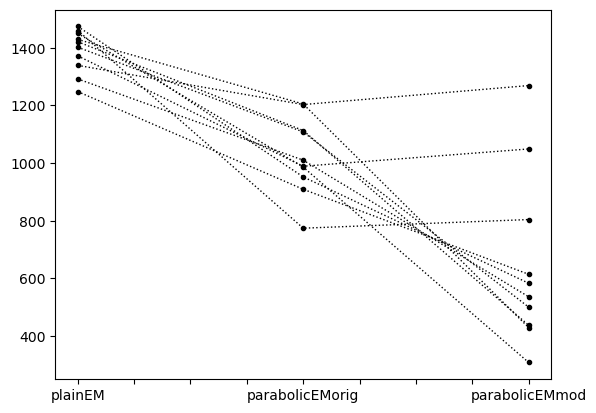

In [10]:
num_iter.plot(marker='o', ls=':', lw=1, ms=3, c='k', legend=False)

In [11]:
def draw_loglik(ax):
    for c, method in zip(('C0', 'C2', 'C1'), ('plainEM', 'parabolicEMorig', 'parabolicEMmod')):
        for rep in range(1, 11):
            tmp = logs.xs((rep, method), level=(0,1))
            mask = tmp['status'].eq('acc-search') & tmp['status'].shift(-1).eq('stdEM')
            tmp = tmp[~mask]
            tmp['loglik'].plot(c=c, alpha=0.8, lw=0.75, ax=ax)

            tmp['loglik'].iloc[-1:].plot(marker=2, ms=3, lw=5, c=c, ax=ax)
            ax.annotate(
                rep, *tmp['loglik'].iloc[-1:].items(), xytext=(-0.5, 8), textcoords='offset points', 
                ha='center', va='top', size='xx-small', c=c
            )

    else:
        for rep in range(1, 11):
            tmp = logs.xs((rep, method), level=(0,1))
            tmp['loglik'].iloc[:1].plot(marker=5, ms=5, mfc='k', mec='none', ax=ax)
            ax.annotate(
                rep, *tmp['loglik'].iloc[:1].items(), xytext=(-5, 0), textcoords='offset points', 
                ha='right', va='center', size='xx-small', c='k'
            )

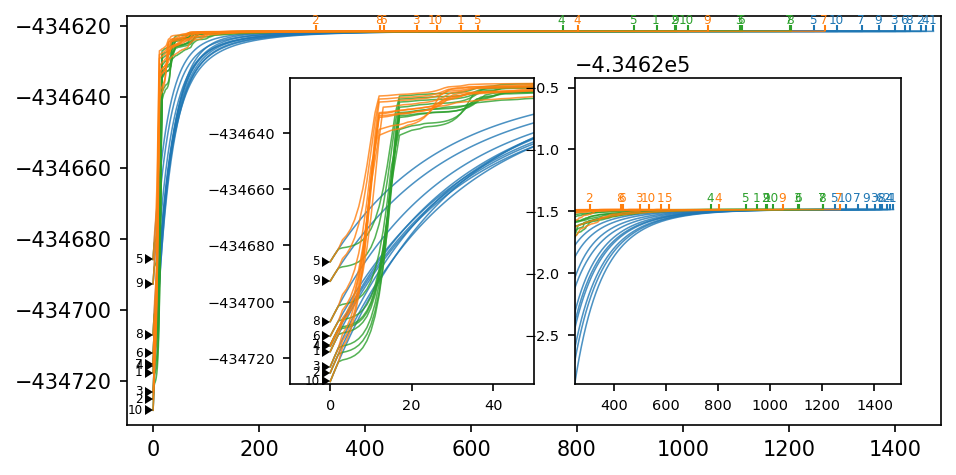

In [12]:
fig, ax = plt.subplots(figsize=(178*mm, 90*mm), dpi=150)

axins1 = ax.inset_axes([0.20, 0.10, 0.30, 0.75])
axins2 = ax.inset_axes([0.55, 0.10, 0.40, 0.75])

draw_loglik(ax)
draw_loglik(axins1)
draw_loglik(axins2)

ax.margins(x=0.01, y=0.04)
ax.set_xlim(left=-50)

axins1.set_xlim(-10, 50)
axins1.margins(y=0.01)
axins1.xaxis.set_tick_params(labelsize='x-small')
axins1.yaxis.set_tick_params(labelsize='x-small')

axins2.set_xlim(250, 1500)
axins2.margins(y=0.01)
axins2.set_ylim(logs.xs(250, level=2)['loglik'].min(), )
axins2.xaxis.set_tick_params(labelsize='x-small')
axins2.yaxis.set_tick_params(labelsize='x-small')

In [13]:
ss = StandardScaler()
pca = PCA(n_components=10)

param_pcs = (
    pd.DataFrame(
        pca.fit_transform(ss.fit_transform(params)), 
        index=logs.index
    )
    .rename(columns=lambda i: f'PC{i+1}')
    .pipe(pd.merge, logs.drop(columns='params'), left_index=True, right_index=True)
)
pca.explained_variance_ratio_

array([0.64280585, 0.12080908, 0.10535825, 0.05744109, 0.02572511,
       0.02016148, 0.01229087, 0.00571892, 0.00342297, 0.00179359])

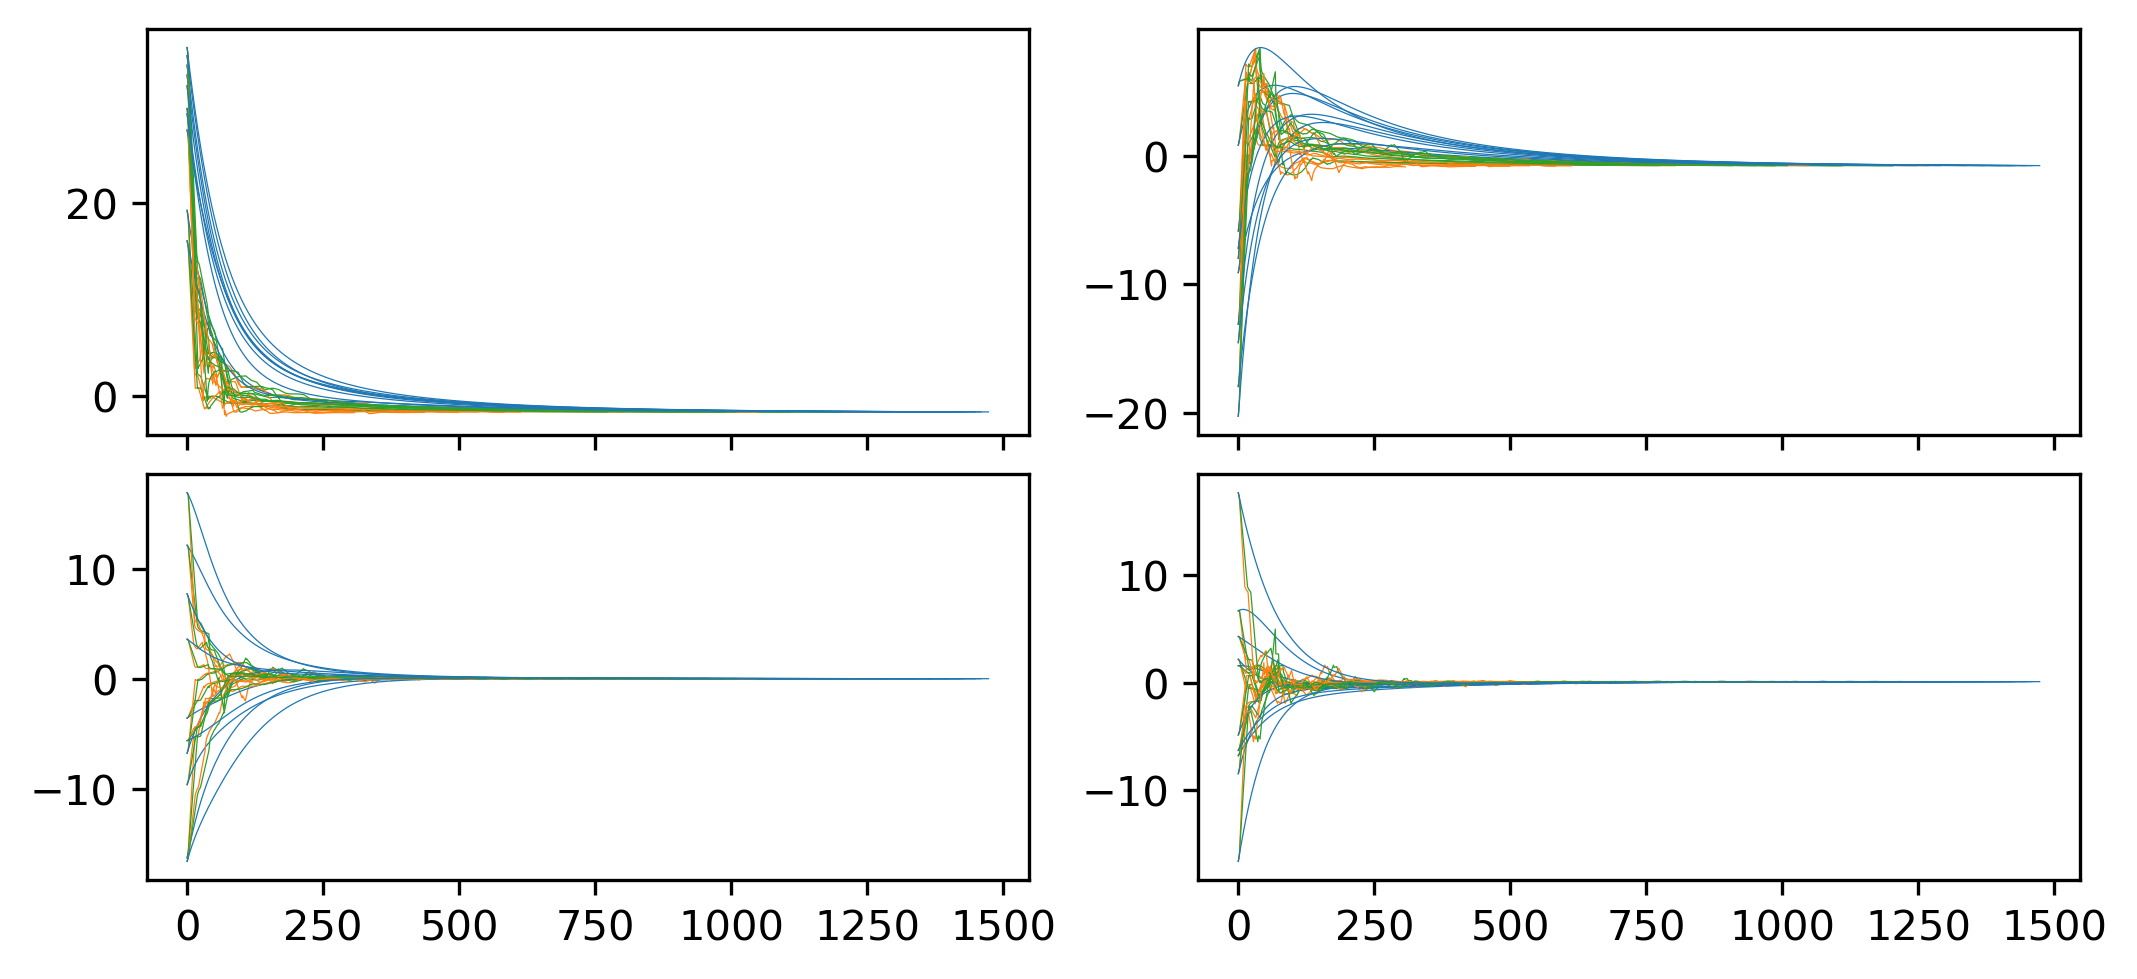

In [14]:
colors = {
    'plainEM'        : 'C0', 
    'parabolicEMorig': 'C2', 
    'parabolicEMmod' : 'C1', 
}

fig, axes = plt.subplots(2, 2, figsize=(178*mm, 80*mm), dpi=300, sharex=True, layout='constrained')

for i, ax in enumerate(axes.flat, start=1):
    for (rep, method), grp in param_pcs.groupby(level=(0,1)):
        (
            grp[f'PC{i}']
            .loc[grp['status'].eq('stdEM')]
            .xs((rep, method), level=(0,1)).loc[0:]
        ).plot(
            ax=ax, c=colors[method], label=method, legend=False, lw=0.3, zorder=0
        )

## Save

In [15]:
logs.drop(columns='params').to_csv(ROOT_DIR/'results'/'misc-EMacc-logs1.tsv.gz', sep='\t')

In [16]:
params.to_csv(ROOT_DIR/'results'/'misc-EMacc-logs2.tsv.gz', sep='\t')